##### STEP 1: 数据加载以及添加column names

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
adult_data_path = "./data/adult.data"
adult_test_path = "./data/adult.test"

columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
           "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
           "hours_per_week", "native_country", "income"]

adult_df = pd.read_csv(adult_data_path, names=columns)
adult_test_df = pd.read_csv(adult_test_path, names=columns)

adult_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


##### STEP 2: 数据清洗

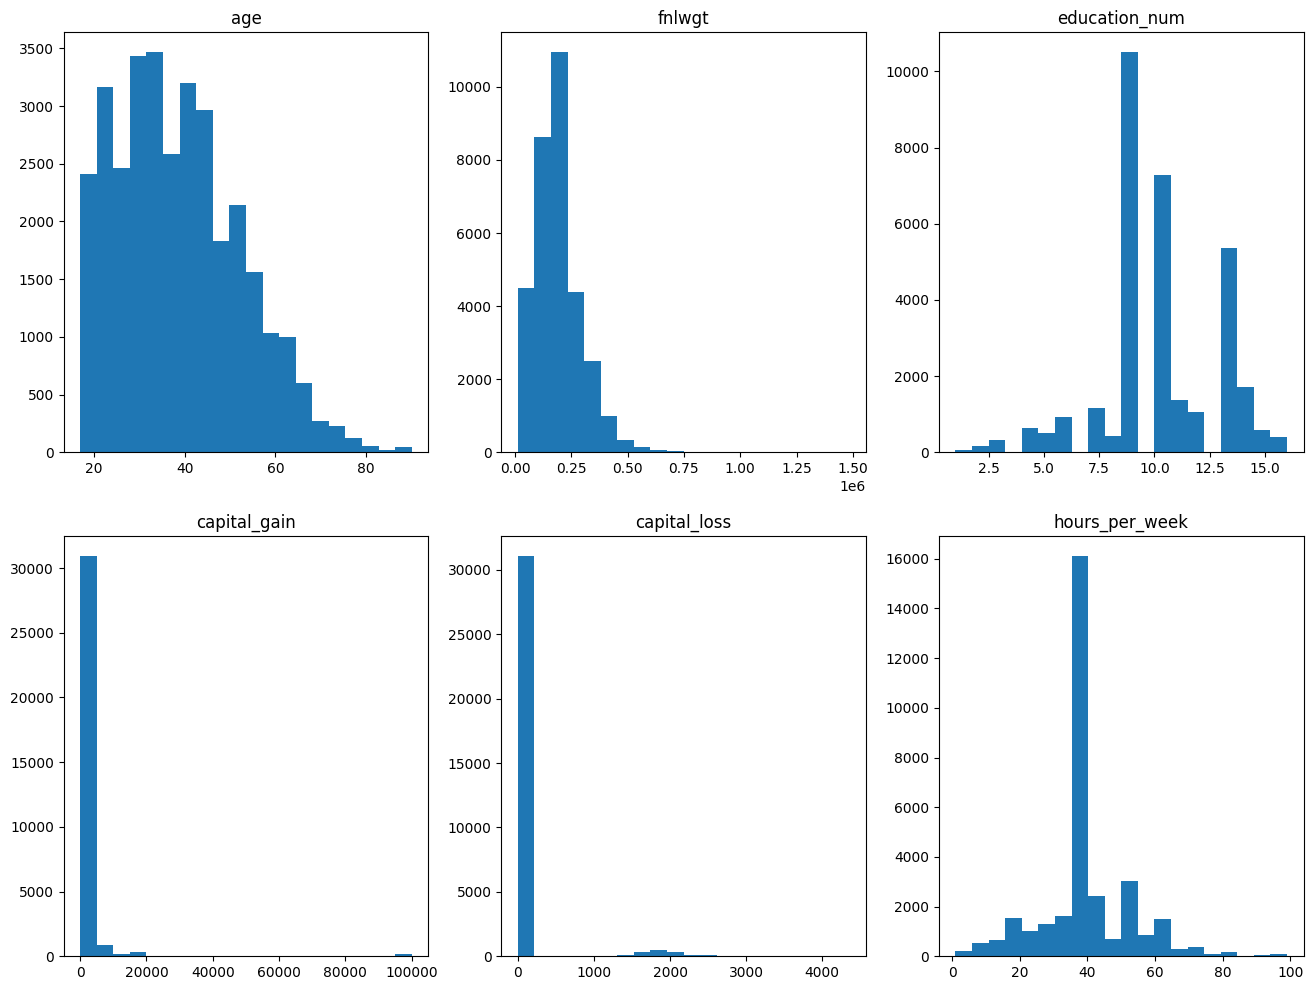

In [3]:
# 针对数值类型的columns，检查其数据分布情况
numerical_columns = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

# 绘制各个字段的数据分布图
fig = plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_columns):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.hist(adult_df[col], bins=20)
    ax.set_title(col)
    
plt.show()

##### 基于上面的数据分布图，可以得出如下分析结论
- capital_gain 和 capital_loss 两个字段的数据过于稀疏，99%以上数据为0，很大概率存在数据缺失，使用这两个数据来分析与收入的相关性的价值可能不高。
- 其他几个字段的数据分布相对正常，没有发现明显的异常数据。

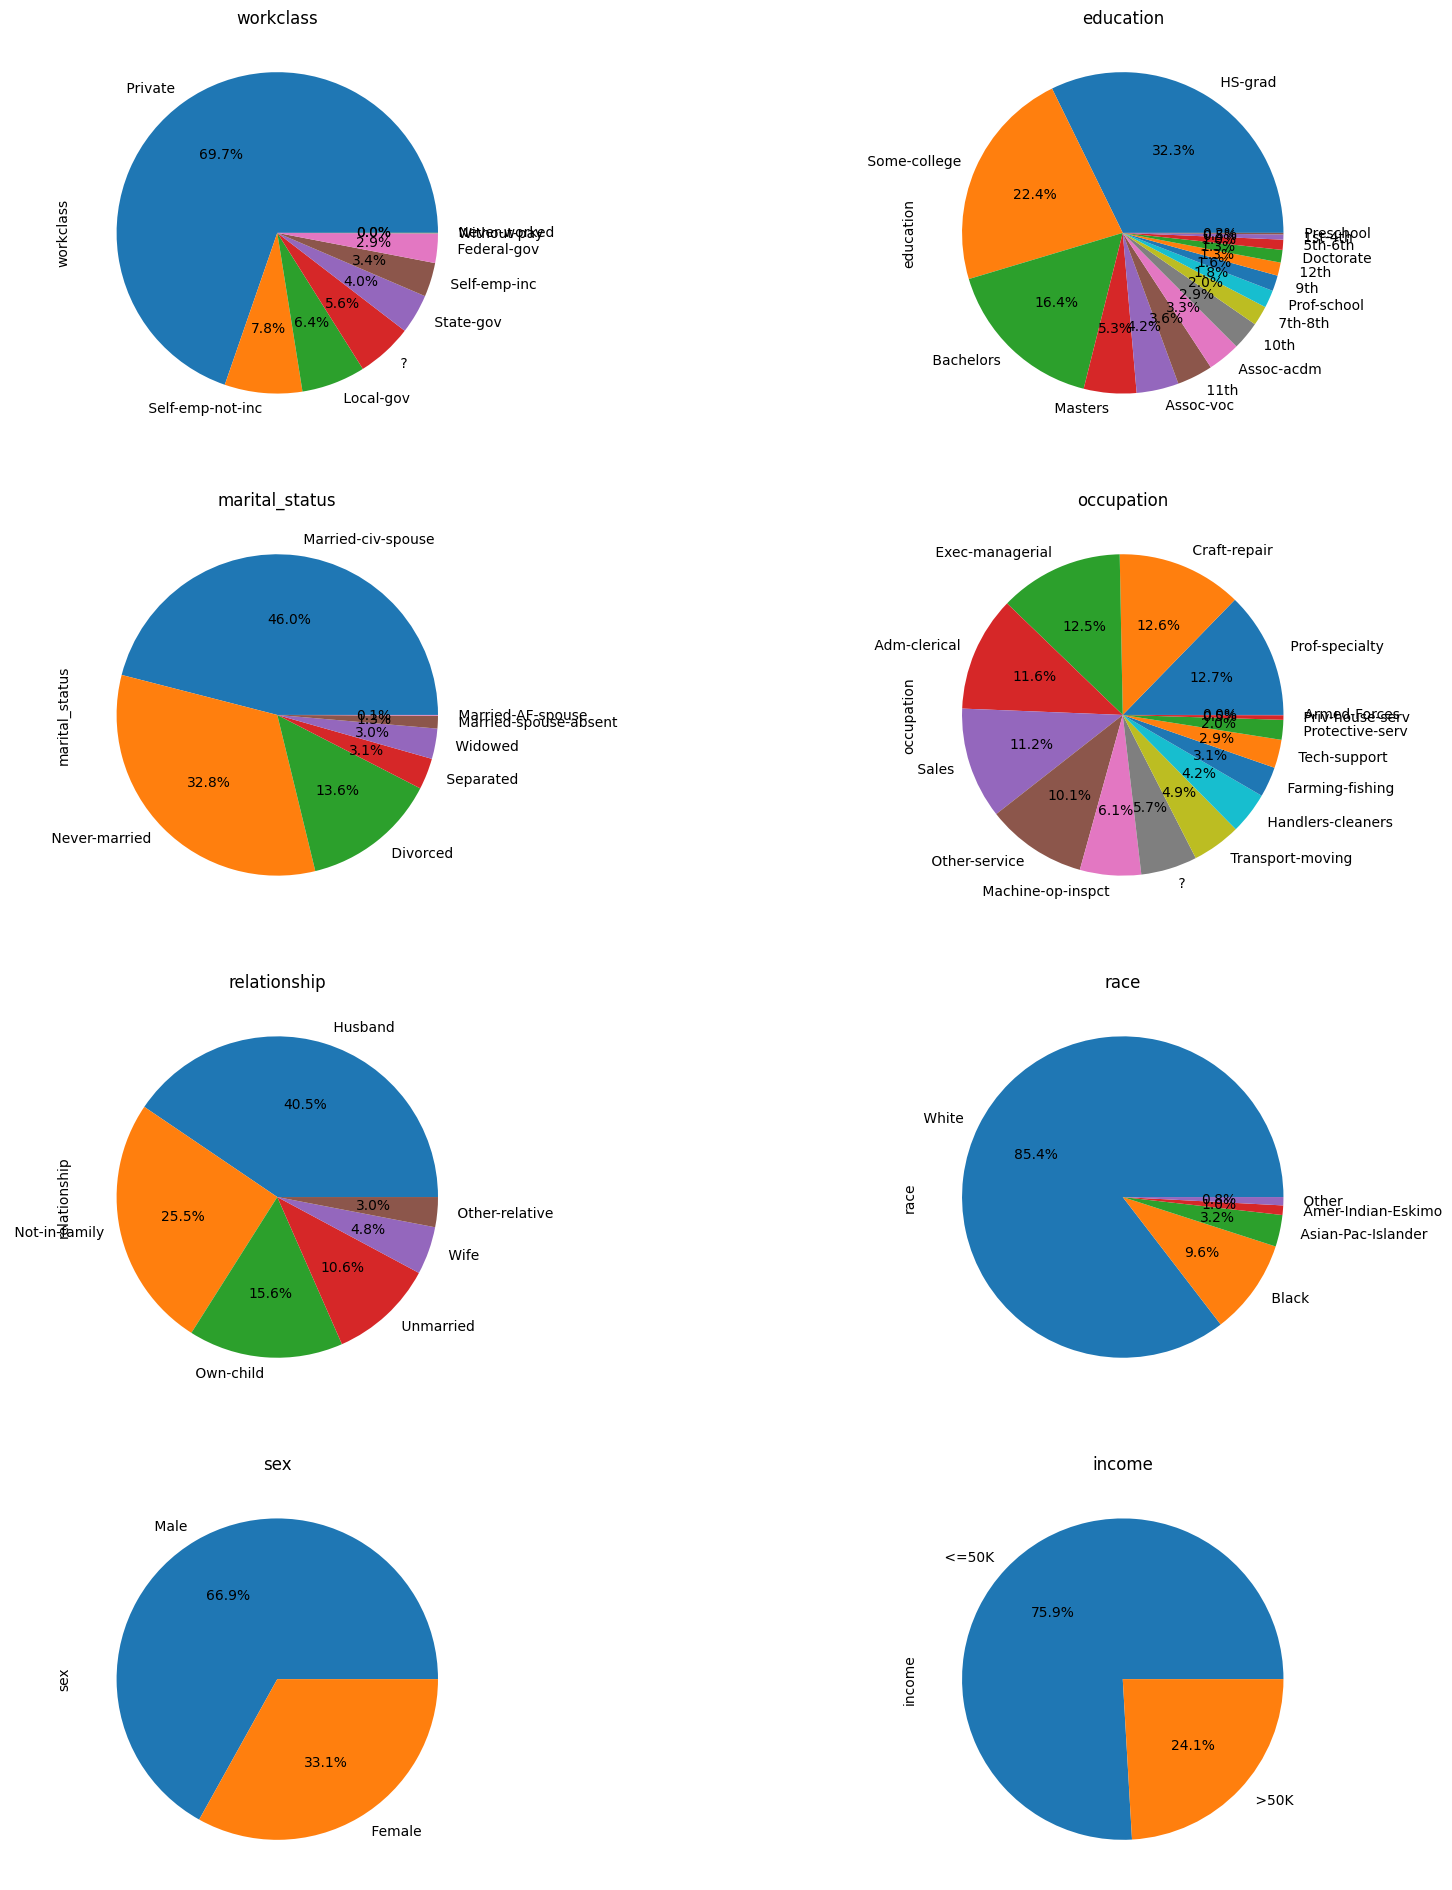

In [4]:
# 针对非数值字段，检查其数据分布情况（native_country字段数量太大，不适合展示，这里不做可视化）
category_columns = ["workclass", "education", "marital_status", "occupation", "relationship",
                    "race", "sex", "income"]

# 绘制各个字段的数据分布图（采用饼图）
fig = plt.figure(figsize=(20, 24))

for i, col in enumerate(category_columns):
    # 增大每个子图的大小
    ax = fig.add_subplot(4, 2, i + 1)
    adult_df[col].value_counts().plot(kind="pie", ax=ax, autopct="%1.1f%%")
    ax.set_title(col)
   
plt.show()

##### 基于上面的数据分布图，可以得出以下结论
- workclass 以及 occupation 两个字段分别存在 5.6% 和 5.7% 的数据缺失，需要对这部分数据进行过滤。
- 其他字段的数据分布正常。

In [5]:
# 进行数据清洗，过滤掉为取值为 ? 的数据
# 第一步需要先去掉所有value值中空格
adult_df = adult_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
adult_test_df = adult_test_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# 统计过滤前的数据量
print("adult_df过滤前的数据量：", adult_df.shape[0])
print("adult_test_df过滤前的数据量：", adult_test_df.shape[0])

# 将 ? 替换为 np.nan
adult_df = adult_df.replace("?", np.nan)
adult_test_df = adult_test_df.replace("?", np.nan)

# 过滤掉为 np.nan 的数据
adult_df_filter = adult_df.dropna()
adult_test_df_filter = adult_test_df.dropna()

# 统计过滤后的数据量
print("adult_df过滤后的数据量：", adult_df_filter.shape[0])
print("adult_test_df过滤后的数据量：", adult_test_df_filter.shape[0])

# 统计异常数据占比（按照百分比输出）
print("adult_df异常数据占比：", (1 - adult_df_filter.shape[0] / adult_df.shape[0]) * 100, "%")
print("adult_test_df异常数据占比：", (1 - adult_test_df_filter.shape[0] / adult_test_df.shape[0]) * 100, "%")

adult_df过滤前的数据量： 32561
adult_test_df过滤前的数据量： 16282
adult_df过滤后的数据量： 30162
adult_test_df过滤后的数据量： 15060
adult_df异常数据占比： 7.367709836921465 %
adult_test_df异常数据占比： 7.505220488883435 %


- 对 age, education_num, hours_per_week 三个字段的数值进行分段处理，方便后续计算与收入的相关性

In [6]:
# 首先对 age 字段进行分段处理
# 0-18岁为少年，18-30岁为青年，30-50岁为中年，50-70岁为老年，70岁以上为老老年
adult_df_filter['age_category'] = pd.cut(adult_df_filter["age"], bins=[0, 18, 30, 50, 70, 100], labels=["child", "youth", "middle", "old", "very_old"])

# 对education_num字段进行分段处理
# n取值为4
# 划分为n个阶段，取最小值和最大值，然后均分为n份
education_num_min = adult_df_filter["education_num"].min()
education_num_max = adult_df_filter["education_num"].max()
edu_num_bins = np.linspace(education_num_min, education_num_max, 4)
adult_df_filter['education_num_category'] = pd.cut(adult_df_filter["education_num"], bins=edu_num_bins, labels=["low", "middle", "high"])

# 对hours_per_week字段进行分段处理
# 划分为n个阶段，取最小值和最大值，然后均分为n份
hours_per_week_min = adult_df_filter["hours_per_week"].min()
hours_per_week_max = adult_df_filter["hours_per_week"].max()
hours_per_week_bins = np.linspace(hours_per_week_min, hours_per_week_max, 4)
adult_df_filter['hours_per_week_category'] = pd.cut(adult_df_filter["hours_per_week"], bins=hours_per_week_bins, labels=["low", "middle", "high"])

adult_df_filter.head()

C:\Users\toofo\AppData\Local\Temp\ipykernel_19944\1487564150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult_df_filter['age_category'] = pd.cut(adult_df_filter["age"], bins=[0, 18, 30, 50, 70, 100], labels=["child", "youth", "middle", "old", "very_old"])
C:\Users\toofo\AppData\Local\Temp\ipykernel_19944\1487564150.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult_df_filter['education_num_category'] = pd.cut(adult_df_filter["education_num"], bins=edu_num_bins, labels=["low", "middle", "hig

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,age_category,education_num_category,hours_per_week_category
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,middle,high,middle
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,middle,high,low
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,middle,middle,middle
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,old,middle,middle
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,youth,high,middle


##### STEP 3: 数据可视化

##### 参考思路

多变量可视化的常见方法包括：

- 散点图矩阵（Scatterplot Matrix）：将数据集中的多个变量两两组合，分别绘制散点图，方便观察不同变量之间的相关性。

- 平行坐标图（Parallel Coordinates Plot）：将数据集中的每个实例（行）抽象为一条线段，每个变量对应线段的一个维度，方便比较不同实例之间的差异。

- 热力图（Heatmap）：将数据集中的多个变量转换成颜色，并在图像上绘制，以展示不同变量之间的关系。

- 三维散点图（3D Scatterplot）：将数据集中的三个变量绘制在三维坐标系中，以观察它们之间的三维关系。

- 树状图（Tree Map）：将数据集中的多个变量组织成树形结构，并用矩形面积来表示各节点的数据值，以便比较不同节点之间的大小关系。

- 聚类散点图（Clustered Scatterplot）：将数据集中的多个变量进行聚类，并将聚类结果绘制为散点图，方便观察不同类别之间的差异。

- 阶梯图（Step Chart）：将时间序列数据或排名数据按顺序绘制，方便观察变量的时序变化或排名变化趋势。

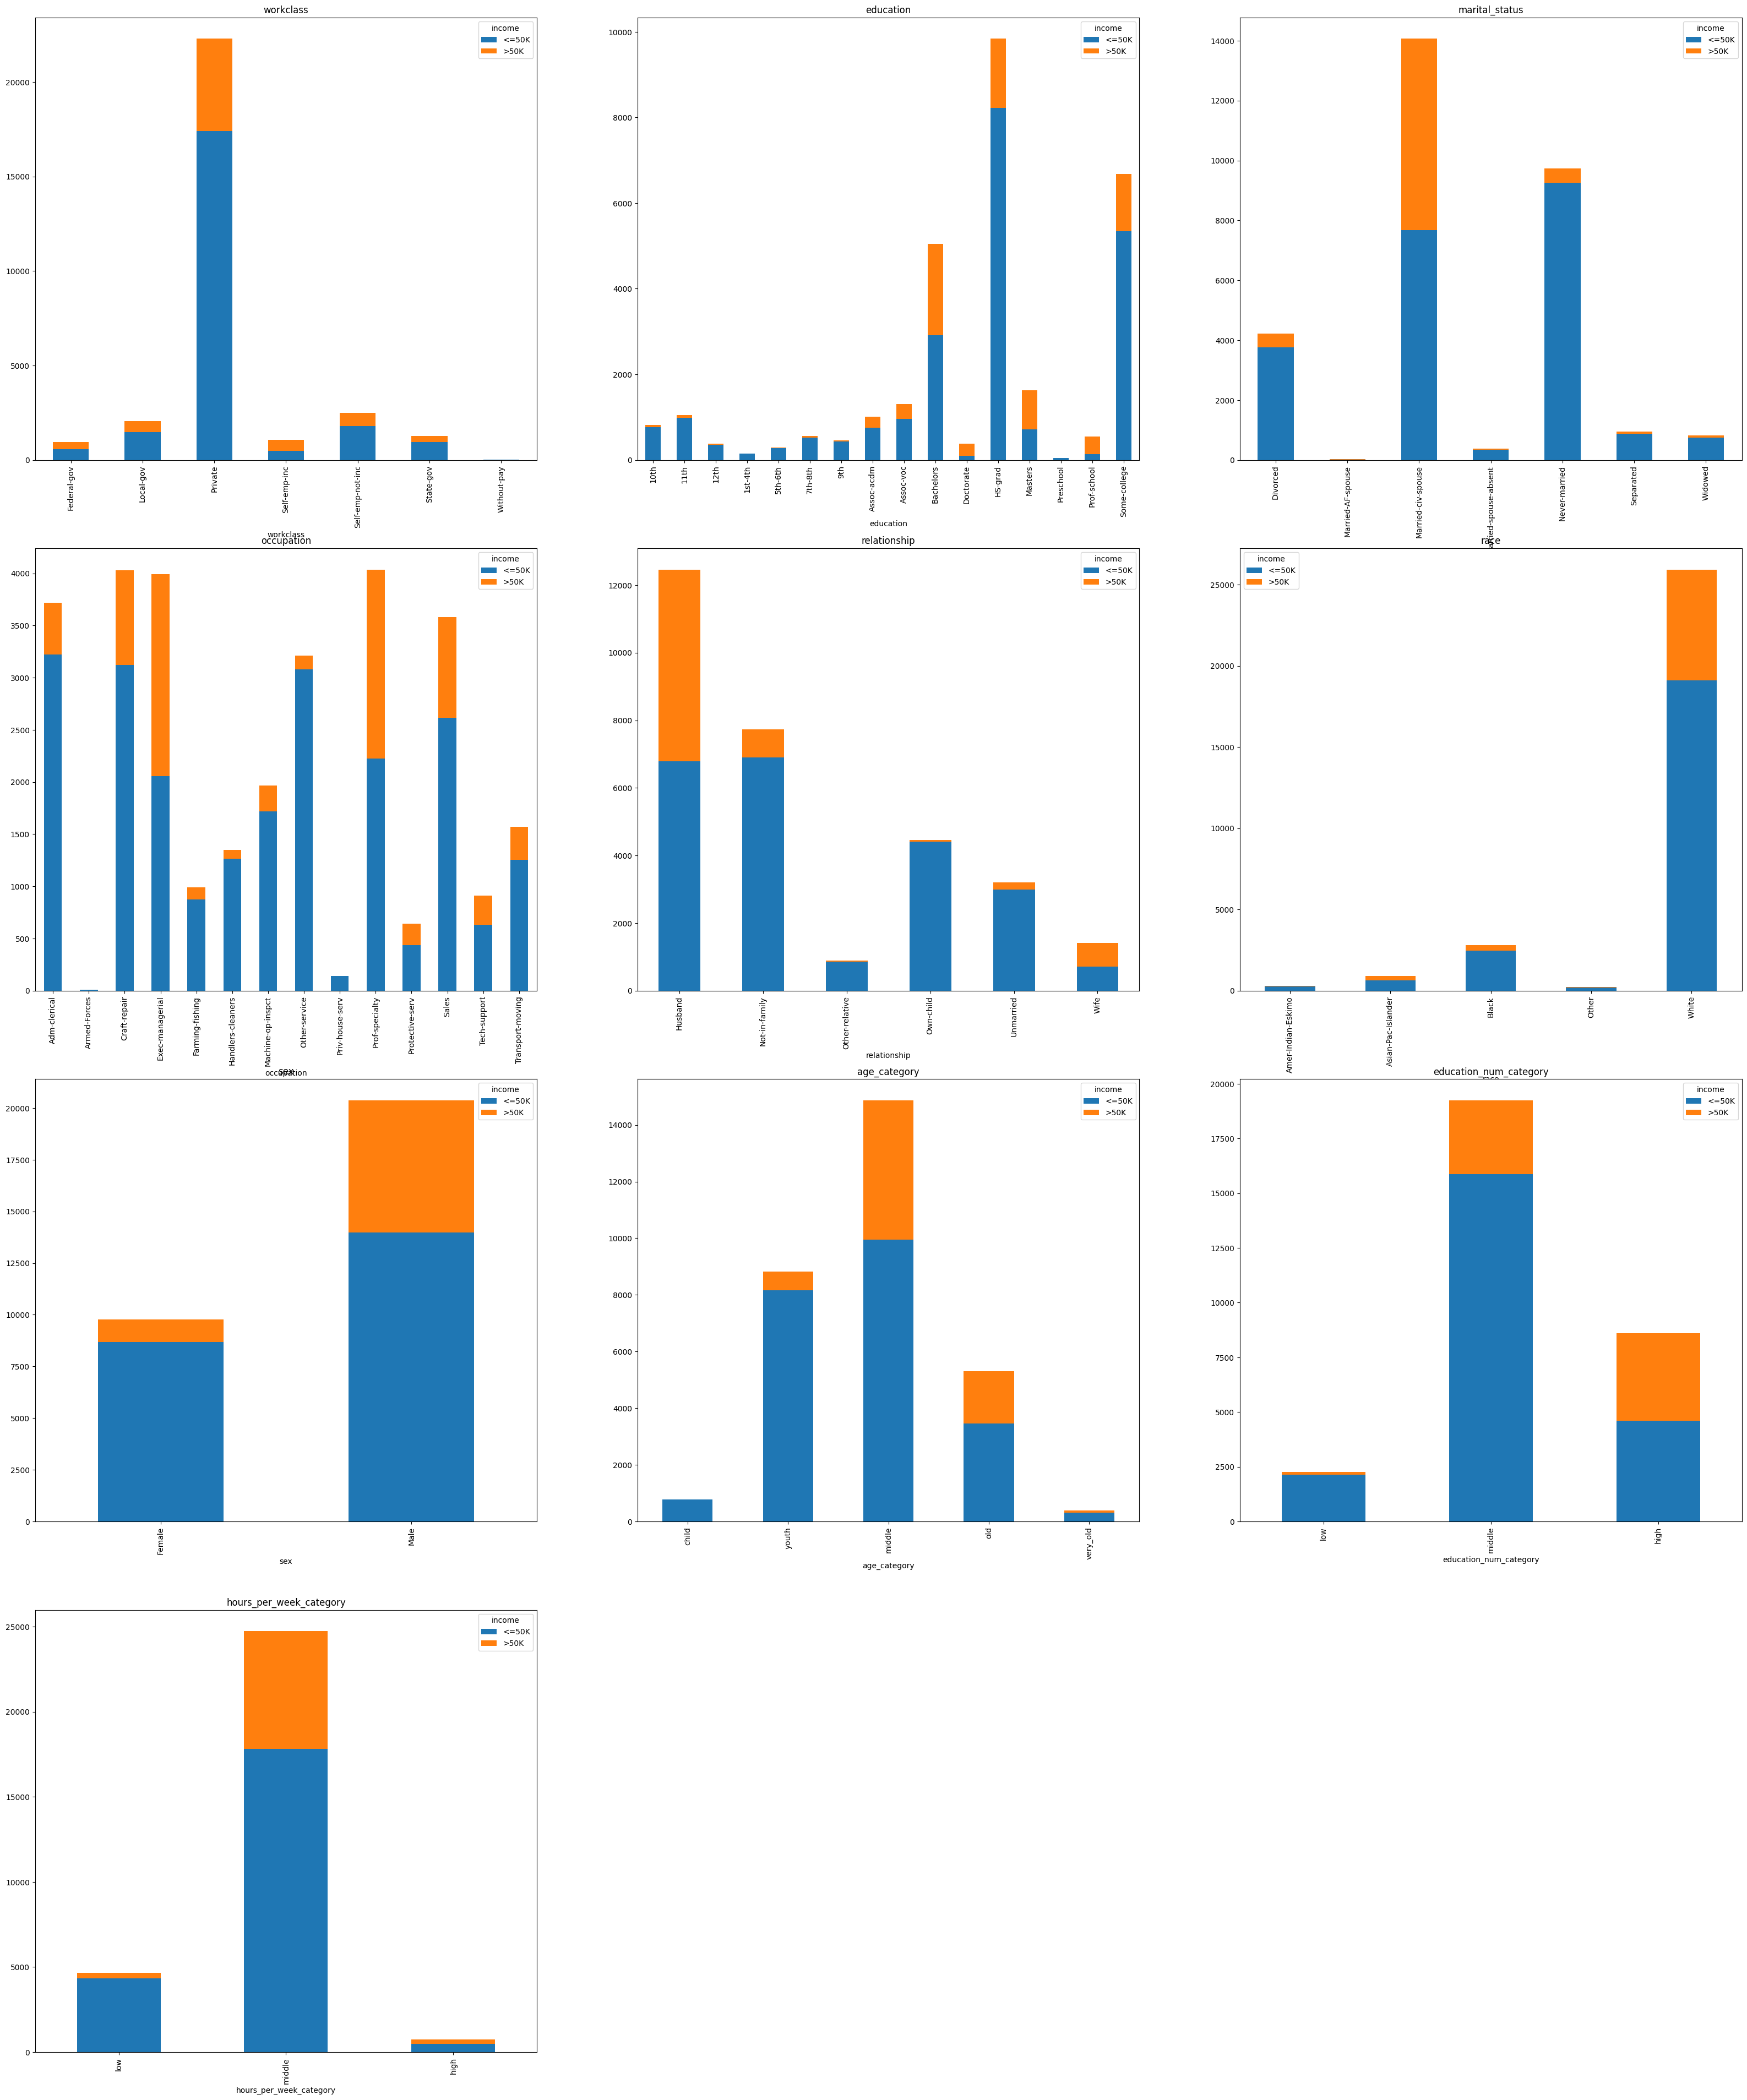

In [7]:
# 首先分析每个字段的不同取值下收入的分布情况，采用柱状图进行可视化
candidate_columns = ["workclass", "education", "marital_status",
                     "occupation", "relationship", "race", "sex",
                     "age_category", "education_num_category", "hours_per_week_category"]

fig = plt.figure(figsize=(40, 48))

for i, col in enumerate(candidate_columns):
    ax = fig.add_subplot(4, 3, i + 1)
    adult_df_filter.groupby([col, "income"]).size().unstack().plot(kind="bar", stacked=True, ax=ax)
    ax.set_title(col)

plt.show()

##### 根据上面的可视化，可以得到一些分析结论：
- 对于收入比较有区分度的变量主要有以下几个： relationship, age_catrgory, education, race, occupation （例如：relationship=Husband的高收入占比明显超出平均值，other-relatively 和 own-child 的则低收入占比显著升高； age 较低或较高的人群低收入占比更高 等。）
- hours_per_week_category 以及 education_num_category 目前分为3段，可以尝试扩大分段数量。
- 进行多变量分析可以优先从 relationship, age_catrgory, education, race, occupation 等变量中选择符合逻辑的组合来进行对比。

##### 可视化的参考选择

- 针对数值类型的几个字段，如 "age", "hours_per_week", "education_num", 采用散点图来观察其与收入关系； 预期的可视化效果：高收入人群的点应该相对集中在青壮年、每周工作时长较长且受教育年限较多的区间；同时低收入人群的点相对集中在年龄较小或较大，工作时长短、且受教育年限短的区间。
- 针对离散类型的字段，如 "sex","relationship", "race", 可以采用热力图，在不同的变量取值组合下，高收入人群的比例越高，图像的颜色越深，反之则越浅。
- 使用平行坐标图可视化（relationship, age_catrgory, education, race, occupation）等相对区分度较高的变量，发掘各变量之间的关系。

##### STEP 3.1  可视化策略1
- 基于 age, hours_per_week, education_num 三个字段, 创建一个3D散点图，其中 x 轴为 age, y 轴为 hours_per_week, z 轴为 education_num，income 的两种取值用不同颜色表示

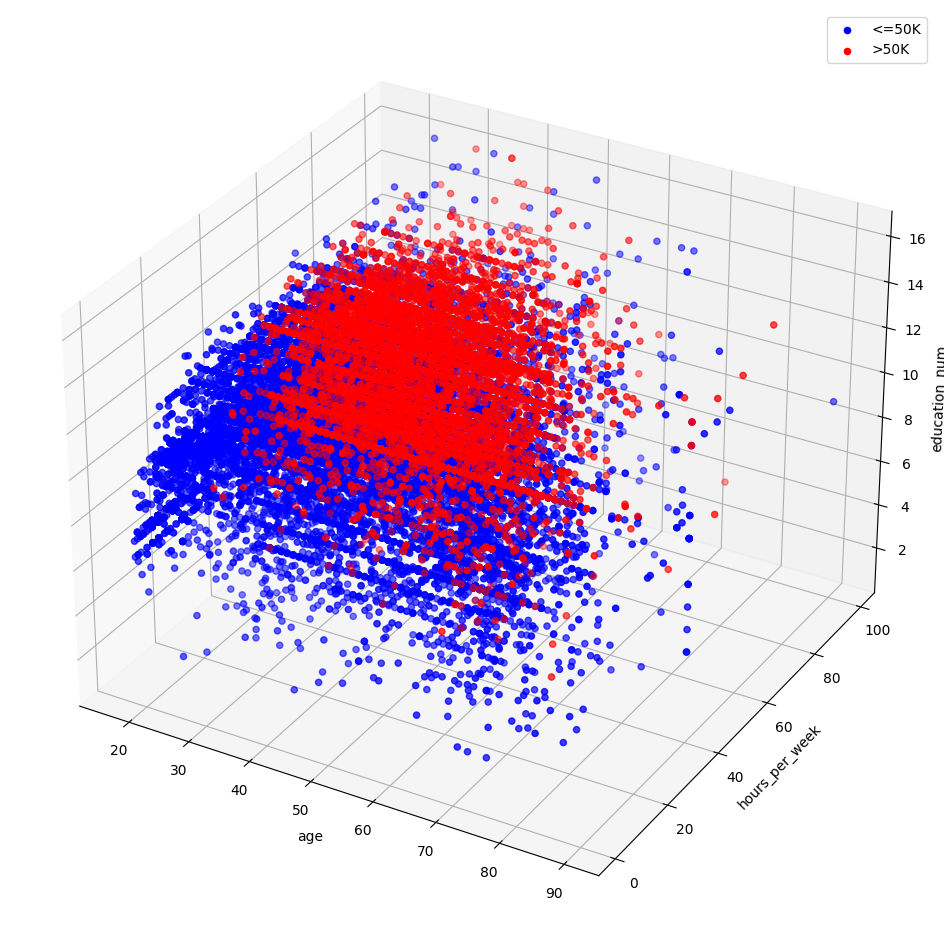

In [8]:
# 基于 age, hours_per_week, education_num 三个字段, 创建一个3D散点图，其中 x 轴为 age, y 轴为 hours_per_week, z 轴为 education_num，income 的两种取值用不同颜色表示
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(adult_df_filter[adult_df_filter["income"] == "<=50K"]["age"],
           adult_df_filter[adult_df_filter["income"] == "<=50K"]["hours_per_week"],
           adult_df_filter[adult_df_filter["income"] == "<=50K"]["education_num"],
           c="blue", label="<=50K")

ax.scatter(adult_df_filter[adult_df_filter["income"] == ">50K"]["age"],
           adult_df_filter[adult_df_filter["income"] == ">50K"]["hours_per_week"],
           adult_df_filter[adult_df_filter["income"] == ">50K"]["education_num"],
           c="red", label=">50K")

ax.set_xlabel("age")
ax.set_ylabel("hours_per_week")
ax.set_zlabel("education_num")

plt.legend(loc="best")
plt.show()

##### 可视化策略1分析
- 可视化的结果与预期相符，低收入的人群主要集中在年龄较小或较大，工作时长短、且受教育年限短的区间；高收入的人群则主要集中在青壮年、每周工作时长较长且受教育年限较多的区间

##### SETP 3.2 可视化策略2
- 针对离散类型的字段 "relationship", "race", 采用热力图来进行可视化展示，在不同的变量取值组合下，高收入人群的比例越高，图像的颜色越深，反之则越浅。

race values: ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
relationship values: ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']


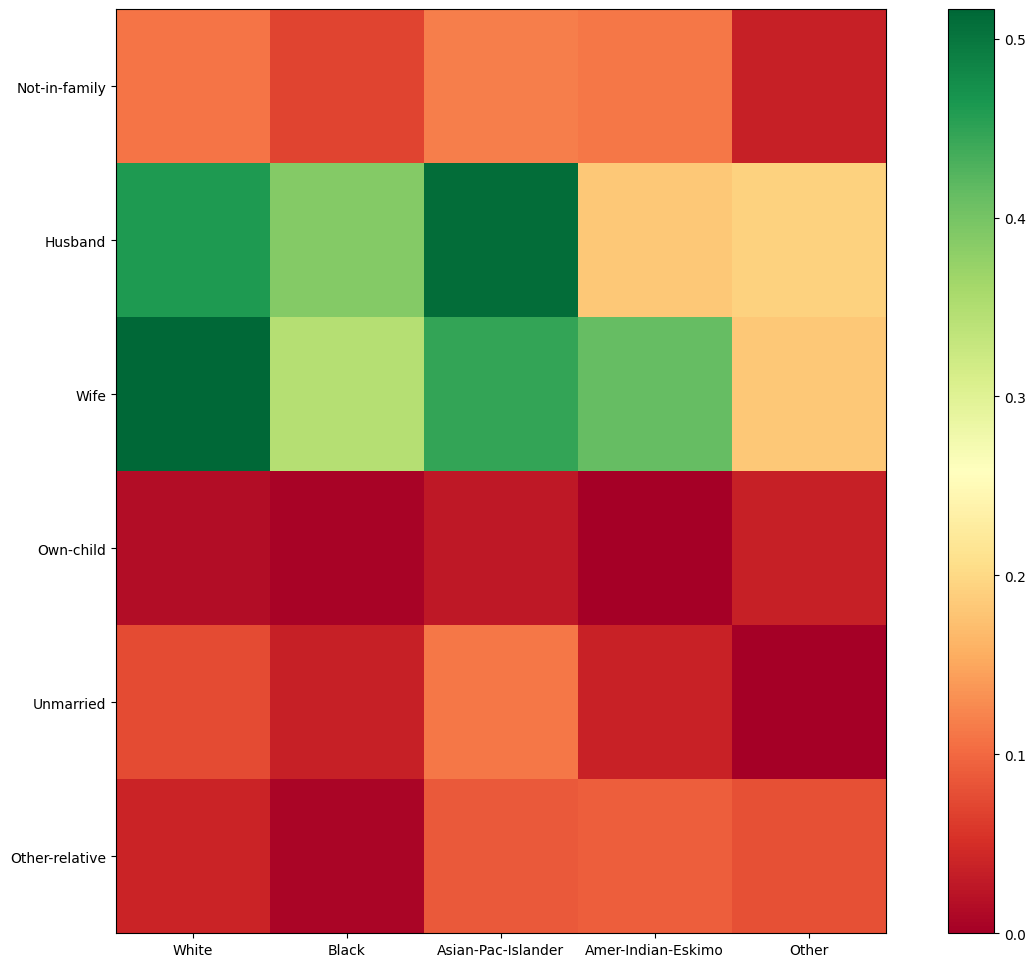

,White,Black,Asian-Pac-Islander,Amer-Indian-Eskimo,Other
Not-in-family,0.110845,0.069577,0.117647,0.111111,0.034483
Husband,0.461538,0.388084,0.508380,0.181818,0.191781
Wife,0.516400,0.345865,0.446429,0.411765,0.181818
Own-child,0.015139,0.004132,0.027586,0.000000,0.034483
Unmarried,0.075609,0.035714,0.111111,0.036364,0.000000
Other-relative,0.039124,0.006849,0.088235,0.090909,0.080000


In [9]:
# "race","relationship", 采用热力图来进行可视化展示，在不同的变量取值组合下，高收入人群的比例越高，图像的颜色越深，反之则越浅。

race_values = adult_df_filter['race'].unique()
relationship_values = adult_df_filter['relationship'].unique()

print("race values:", race_values)
print("relationship values:", relationship_values)

# 构建一个二维数组，用于存储不同变量取值组合下，高收入人群的比例
hight_income_ratio = {}

# 遍历每一行数据，统计不同变量取值组合下，高收入人群的比例
for index, row in adult_df_filter.iterrows():
    race_v = row['race']
    relation_v = row['relationship']
    if race_v not in hight_income_ratio:
        hight_income_ratio[race_v] = {}
        
    if relation_v not in hight_income_ratio[race_v]:
        hight_income_ratio[race_v][relation_v] = [0, 0]
    
    if row['income'] == '>50K':
        hight_income_ratio[race_v][relation_v][0] += 1
    
    hight_income_ratio[race_v][relation_v][1] += 1

# 计算比例
for race_v in race_values:
    for relation_v in relationship_values:
        ratio = hight_income_ratio[race_v][relation_v][0]/hight_income_ratio[race_v][relation_v][1]
        hight_income_ratio[race_v][relation_v] = ratio


# 转换为 DataFrame
hight_income_ratio_df = pd.DataFrame(hight_income_ratio)

hight_income_ratio_df
fig = plt.figure(figsize=(16, 12))

# Displaying dataframe as an heatmap
# with diverging colormap RdYlGn
plt.imshow(hight_income_ratio_df, cmap='RdYlGn', interpolation='nearest')
  
# Displaying a color bar to understand
# which color represents which range of data
plt.colorbar()
  
# Assigning labels of x-axis 
# according to dataframe
plt.xticks(range(len(hight_income_ratio_df.columns)), hight_income_ratio_df.columns)
  
# Assigning labels of y-axis 
# according to dataframe
plt.yticks(range(len(hight_income_ratio_df.index)), hight_income_ratio_df.index)
  
# Displaying the figure
plt.show()

hight_income_ratio_df

##### 可视化策略2分析
- 通过热力图可以看出，White+Wife 以及 Asian-Pac-Islander+Husband 的变量组合高收入占比最高，black+Own-child 以及 black+Other-relative 的变量组合低收入占比最高。

##### 可视化策略3
- 使用平行坐标图可视化（relationship, age_catrgory, education, race, occupation）等相对区分度较高的变量，发掘各变量之间的关系

In [16]:
# 使用平行坐标图，分析不同的变量取值组合下，income 的分布情况
import plotly.graph_objects as go

def parallel_coordinates_plot(df, cols, hue_col, title):
    dimensions = list()
    for col in cols:
        unique_values = df[col].unique()
        col_value_map = dict()
        for i, val in enumerate(unique_values):
            col_value_map[val] = i + 1 
        col_values = [col_value_map[val] for val in df[col]]
        dim = dict(range = [1, len(unique_values)],
                   tickvals = [i for i in range(1, len(unique_values) + 1)],
                   ticktext = unique_values,
                   label = col, values = col_values)
        dimensions.append(dim)
        
    hue_values = df[hue_col].unique()
    color_map = dict()
    for i, hue_value in enumerate(hue_values):
        color_map[hue_value] = i + 1
    
    colors = [color_map[val] for val in df[hue_col]]
    fig = go.Figure(data=
        go.Parcoords(
            line = dict(color = colors,
                       colorscale = 'RdYlGn',
                       showscale = True,
                       reversescale = True),
            dimensions = dimensions
        )
    )

    fig.update_layout(
        title=title,
        plot_bgcolor = 'white',
        paper_bgcolor = 'white'
    )

    fig.show()


plot_df = adult_df_filter[['relationship', 'age_category', 'education', 'race', 'occupation', 'income']]
# 随机抽样n条数据，避免数据量过大导致图像过于密集
sample_n = 500
plot_df = plot_df.sample(n=sample_n)

parallel_coordinates_plot(plot_df, cols=['relationship', 'age_category', 'education', 'race', 'occupation', 'income'], hue_col='income', title='Parallel Coordinates Plot')

##### 可视化策略3分析
- 通过平行坐标图，可以看出，高收入人群相关性更强的变量包括：relationship-husband, relationship-wife, age-middle, age-old 以及 race-white。
- 低收入人群相关性最强的变量包括： relationship-ownchild, age-veryold, age-child, education-1st-4th, 以及 race-other.